## **Exercise**

1. Load the [dataset](https://www.kaggle.com/datasets/lakshmi25npathi/bike-sharing-dataset) from Kaggle. Use the "hour.csv" file.
2. Visualize the structure of the dataset using appropriate libraries and plots.
3. Clean and pre-process the dataset as required and prepare the data for modelling.
4. Create the lag and rolling windows features for the "cnt" column such as: 1 day lag, 1 week lag, 1 month, etc. and last 3 day rolling mean, last 3 hours rolling mean, etc. But it should be based on your dataset and what makes sense for this dataset.
6. Implement XGBoost to predict how many bikes will be rented each hour of the last week and evaluate using appropriate metrics.

The hand-in exercise for this topic is Task 3,4 and 6 from the notebook “TSA_Task”. This 
means that you have to do the cleaning of dataset, then create features (at least 5 new 
features should be created, and you should be able to justify why you created each of the 
features). And then, you should train an XGBoost model on the dataset. Note that you also 
need to do relevant train, test, validation split and be able to explain why you chose a 
certain split. Lastly, you should calculate evaluation metrics: rmse and mae to show 
performance of your model. The hyperparameter tuning part is not required. 

In [3]:
import os
import kagglehub

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
#loding house.csv dataset
df = pd.read_csv("hour.csv")
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


2. Visualize the structure of the dataset using appropriate libraries and plots.
* Visualize Dataset Structure

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [6]:
df.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [7]:
df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

* we have 16 numerical variables (float64(4), int64(12)) and one categorical variable (dteday: date). we have no null value is the dataset.

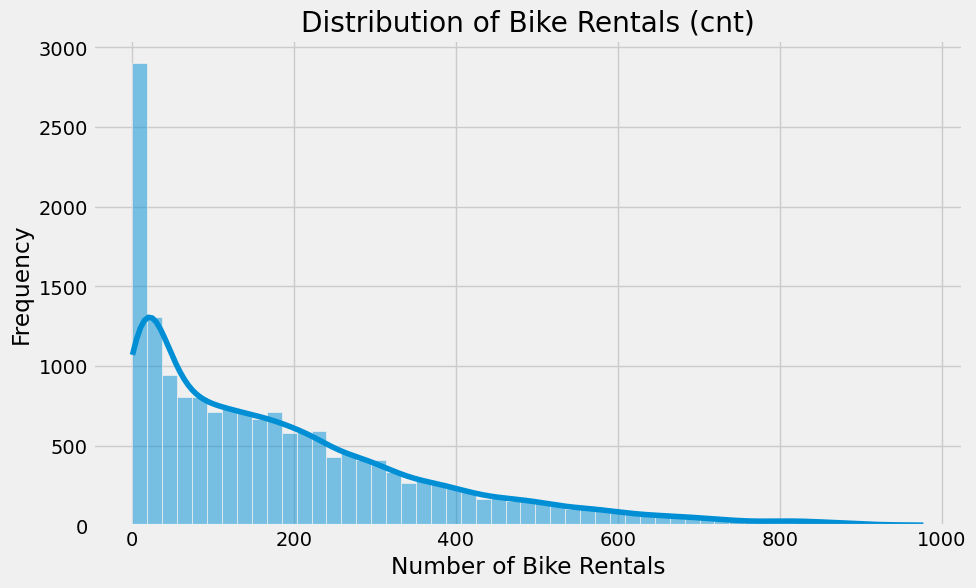

In [8]:
# Visualize the distribution of the target variable 'cnt'
plt.figure(figsize=(10, 6))
sns.histplot(df['cnt'], kde=True)
plt.title('Distribution of Bike Rentals (cnt)')
plt.xlabel('Number of Bike Rentals')
plt.ylabel('Frequency')
plt.show()

In [9]:
#creating 'datetime' by adding dteday+hr+:00:00
df['datetime'] = pd.to_datetime(df['dteday'] + ' ' + df['hr'].astype(str) + ':00:00')
df['datetime']

0       2011-01-01 00:00:00
1       2011-01-01 01:00:00
2       2011-01-01 02:00:00
3       2011-01-01 03:00:00
4       2011-01-01 04:00:00
                ...        
17374   2012-12-31 19:00:00
17375   2012-12-31 20:00:00
17376   2012-12-31 21:00:00
17377   2012-12-31 22:00:00
17378   2012-12-31 23:00:00
Name: datetime, Length: 17379, dtype: datetime64[ns]

3. Clean and pre-process the dataset as required and prepare the data for modelling.

In [10]:
# taking datetime and cnt
df_clen=df[['datetime','cnt']]
df_clen

,datetime,cnt
0,2011-01-01 00:00:00,16
1,2011-01-01 01:00:00,40
2,2011-01-01 02:00:00,32
3,2011-01-01 03:00:00,13
4,2011-01-01 04:00:00,1
...,...,...
17374,2012-12-31 19:00:00,119
17375,2012-12-31 20:00:00,89
17376,2012-12-31 21:00:00,90
17377,2012-12-31 22:00:00,61


In [11]:
# We are setting the 'datetime' column as the index of our DataFrame. 
# We are ensuring that the index is of datetime64 data type for proper time series handling, 
# and sorting the DataFrame chronologically by the datetime index.
df_clen = df_clen.set_index('datetime')
df_clen.index = pd.to_datetime(df_clen.index)
df_clen = df_clen.sort_index()
df_clen

,cnt
datetime,
2011-01-01 00:00:00,16
2011-01-01 01:00:00,40
2011-01-01 02:00:00,32
2011-01-01 03:00:00,13
2011-01-01 04:00:00,1
...,...
2012-12-31 19:00:00,119
2012-12-31 20:00:00,89
2012-12-31 21:00:00,90


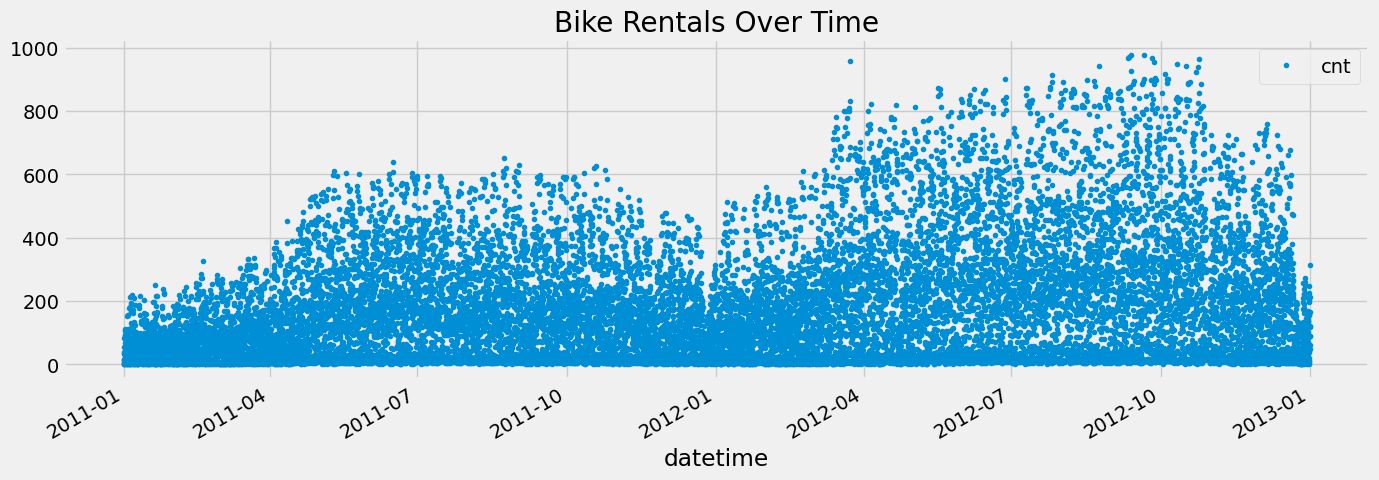

In [12]:
# Visualising the DataFrame
df_clen.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='Bike Rentals Over Time')
plt.show()

<Figure size 640x480 with 0 Axes>

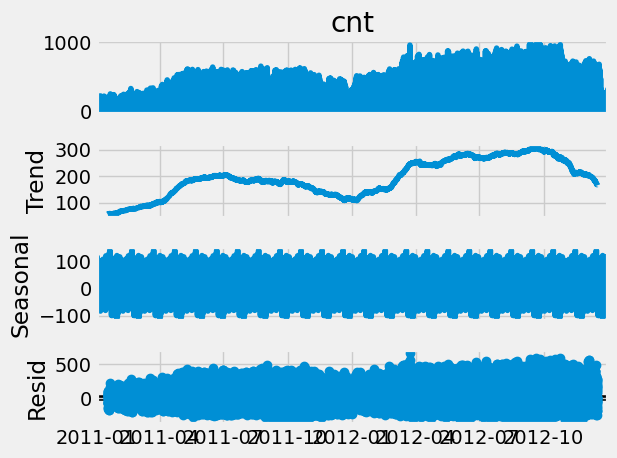

In [13]:
plt.clf()
# Perform seasonal decomposition
result = seasonal_decompose(df_clen['cnt'], model='additive', period=(24*30))  # Assuming monthly seasonality

# Plot decomposition
result.plot()
plt.show()

In [14]:
# Get the last 1 week of data
shorter_df = df_clen.tail(7*24) # Assuming 1 week data, so 7 days * 24 hours

shorter_df.head()

,cnt
datetime,
2012-12-24 23:00:00,11
2012-12-25 00:00:00,13
2012-12-25 01:00:00,13
2012-12-25 02:00:00,7
2012-12-25 04:00:00,1


<Figure size 640x480 with 0 Axes>

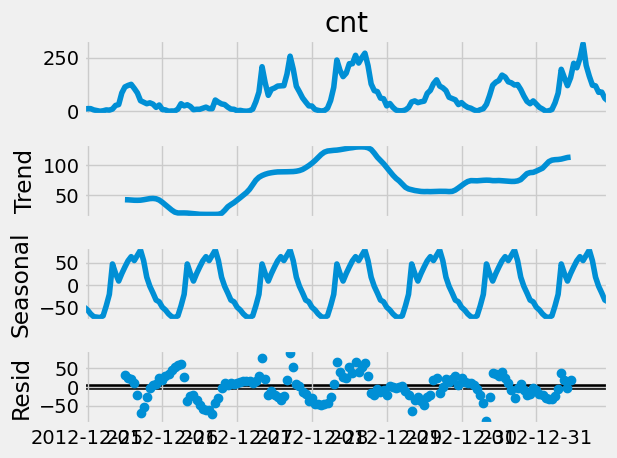

In [15]:
plt.clf()
# Perform seasonal decomposition
result = seasonal_decompose(shorter_df['cnt'], model='additive', period=24)  # Assuming hourly data

# Plot decomposition
result.plot()
plt.show()

## **Train/Test Split**

<Figure size 640x480 with 0 Axes>

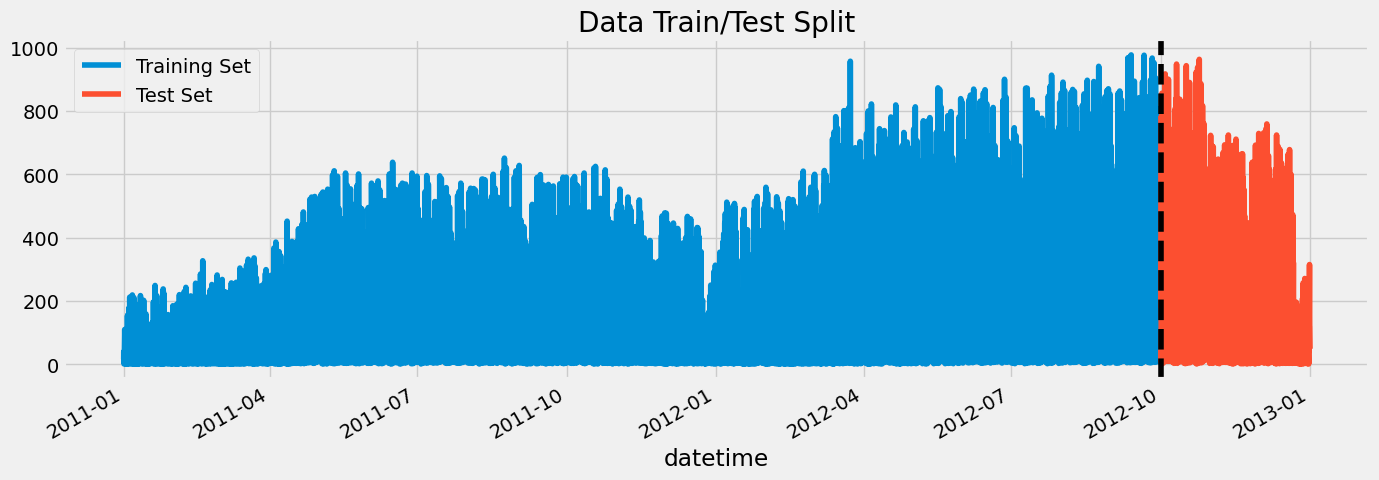

In [16]:
# Splitting the dataset to train and test data
train = df_clen.loc[df_clen.index < '10-01-2012']
test = df_clen.loc[df_clen.index >= '10-01-2012']
plt.clf()
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('10-01-2012', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

<Figure size 640x480 with 0 Axes>

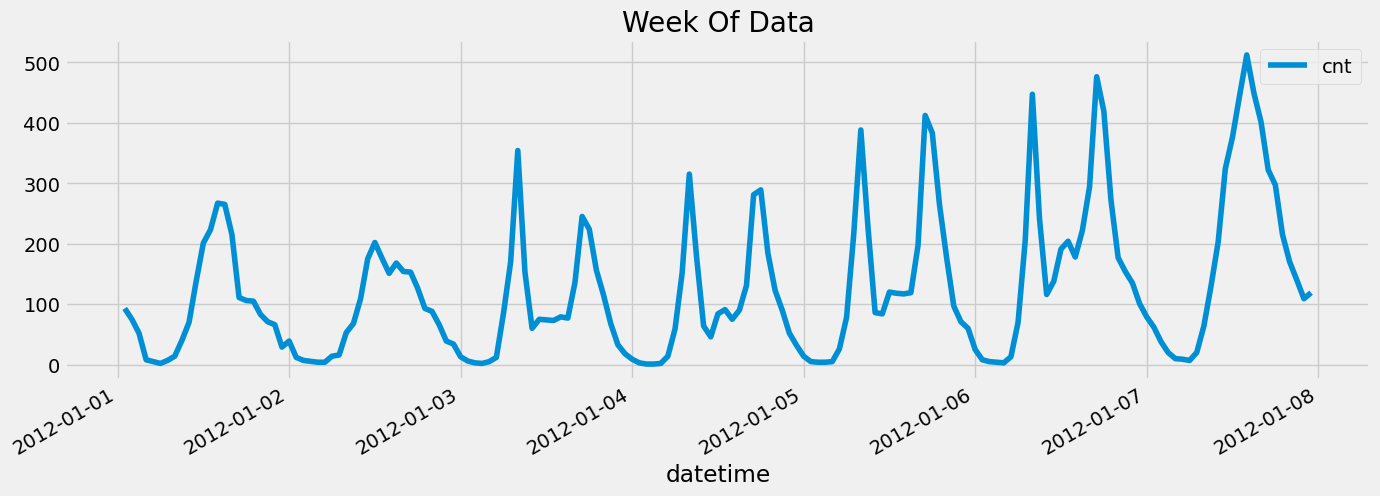

In [17]:
# looking one week data (from 01-02-2012 to 01-08-2012)
plt.clf()
df_clen.loc[(df_clen.index > '01-01-2012') & (df_clen.index < '01-08-2012')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

4. Create the lag and rolling windows features for the "cnt" column such as: 1 day lag, 1 week lag, 1 month, etc. and last 3 day rolling mean, last 3 hours rolling mean, etc. But it should be based on your dataset and what makes sense for this dataset.

In [18]:
# adding Basic time-based features, Lag features, and Rolling statistics features
def create_features(df):
    """
    Create time series features and lag features based on time series index.
    """
    df = df.copy()

    # Basic time-based features
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    # Lag features
    df['lag_1d'] = df['cnt'].shift(24)   # 1 day lag
    df['lag_1w'] = df['cnt'].shift(24*7)   # 1 week lag
    df['lag_1m'] = df['cnt'].shift(24*30)  # 1 month lag (approx. 30 days)
    df['lag_1y'] = df['cnt'].shift(24*365) # 1 year lag

    # Rolling statistics features
    df['rolling_mean_3h'] = df['cnt'].rolling(window=3).mean()  # Last 3 hours rolling mean
    df['rolling_mean_1d'] = df['cnt'].rolling(window=24).mean()  # Last 24 hours rolling mean
    df['rolling_mean_3d'] = df['cnt'].rolling(window=24*3).mean()  # Last 3 days rolling mean
    df['rolling_mean_1w'] = df['cnt'].rolling(window=24*7).mean()  # Last 7 days rolling mean
    df['rolling_mean_30d'] = df['cnt'].rolling(window=24*30).mean()  # Last month rolling mean
    df['rolling_mean_same_month_last_year'] = df['cnt'].shift(24*365).rolling(window=24*30).mean()  # Same month previous year rolling mean
    df['rolling_mean_same_week_last_year'] = df['cnt'].shift(24*365).rolling(window=24*7).mean()  # Same week previous year rolling mean

    return df

In [19]:
df_clen = create_features(df_clen)

<Figure size 640x480 with 0 Axes>

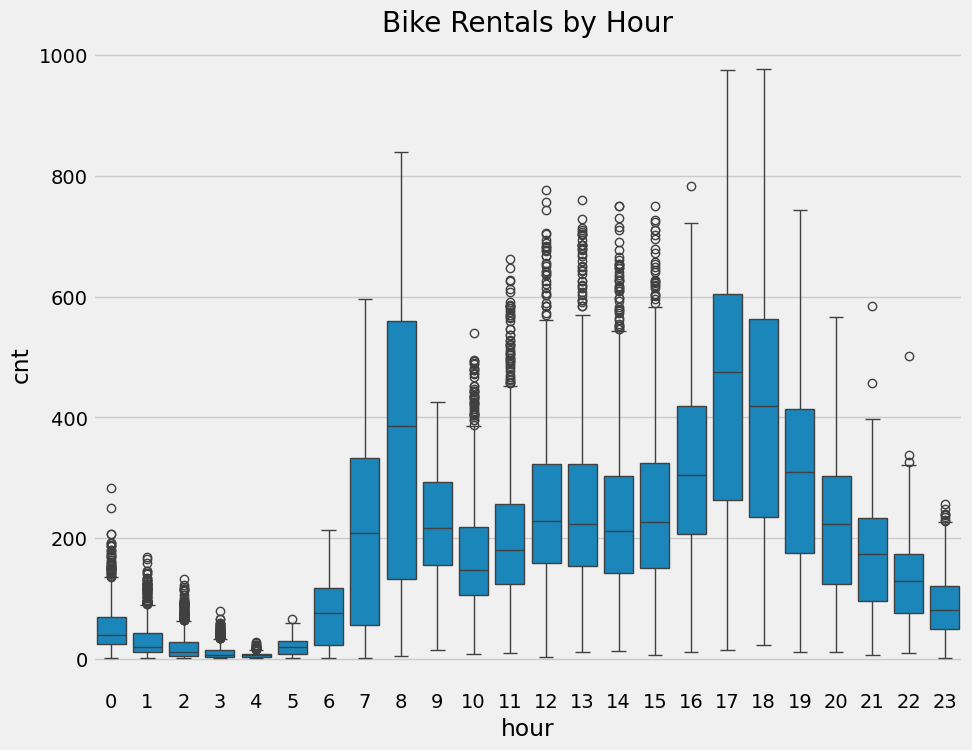

In [20]:
# boxploting data per hour 
plt.clf()
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_clen, x='hour', y='cnt')
ax.set_title('Bike Rentals by Hour')
plt.show()

C:\Users\victo\AppData\Local\Temp\ipykernel_15956\2563937667.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clen, x='month', y='cnt', palette='Blues')


<Figure size 640x480 with 0 Axes>

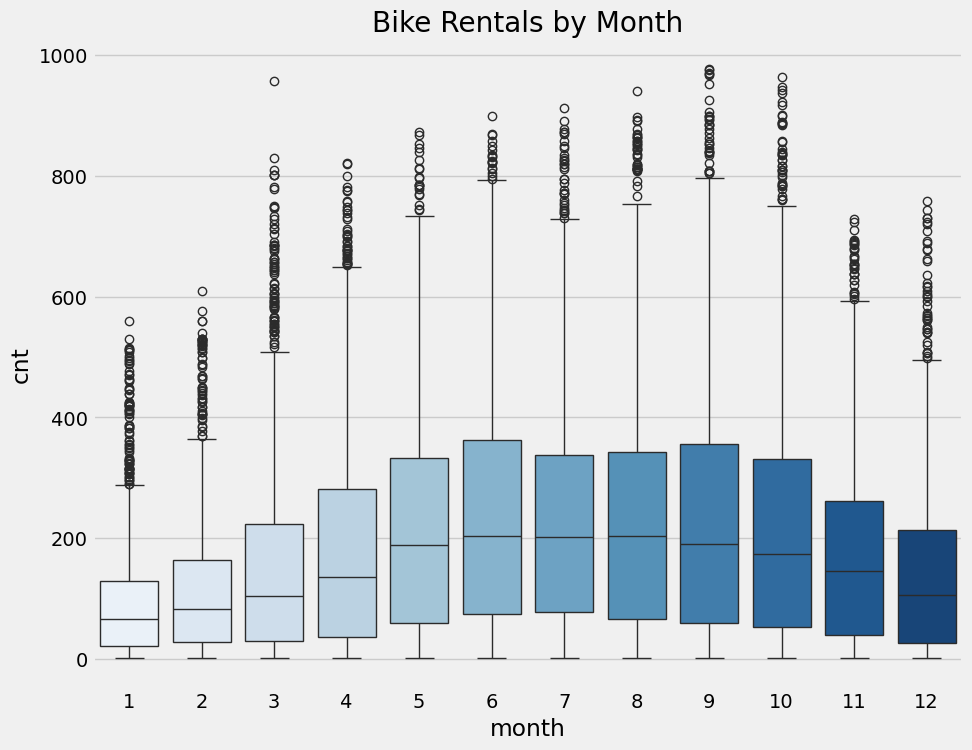

In [21]:
# boxploting data per month
plt.clf()
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_clen, x='month', y='cnt', palette='Blues')
ax.set_title('Bike Rentals by Month')
plt.show()

6. Implement XGBoost to predict how many bikes will be rented each hour of the last week and evaluate using appropriate metrics.

In [22]:
# prepering target and features for XGBoost
train = create_features(train)
test = create_features(test)


TARGET = 'cnt'


FEATURES_XGB = [
    'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
    'lag_1d', 'lag_1w', 'lag_1m', 'lag_1y',
    'rolling_mean_3h','rolling_mean_1d','rolling_mean_1w','rolling_mean_3d', 'rolling_mean_30d', 'rolling_mean_same_month_last_year', 'rolling_mean_same_week_last_year'
]


In [23]:
# XGBoost Data
X_train_xgb = train[FEATURES_XGB]
y_train_xgb = train[TARGET]

X_test_xgb = test[FEATURES_XGB]
y_test_xgb = test[TARGET]





# **XGBoost**

In [24]:
# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train_xgb, label=y_train_xgb)
dtest = xgb.DMatrix(X_test_xgb, label=y_test_xgb)

# Set parameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # Objective function for regression
    'eval_metric': 'rmse',  # Evaluation metric
    'max_depth': 3,  # Depth of the trees
    'learning_rate': 0.01,  # Learning rate
    'colsample_bytree': 0.8,  # Subsample of features
    'subsample': 0.8  # Subsample ratio
}

# Watchlist for monitoring performance on train and test sets
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# Number of boosting rounds and early stopping
num_round = 1000  # Number of boosting rounds
early_stopping_rounds = 50  # Early stopping

# Train the model
reg = xgb.train(params, dtrain, num_round, watchlist, early_stopping_rounds=early_stopping_rounds,verbose_eval=100)

# # Predict on the test set
y_pred_xgb = reg.predict(dtest)

# # Evaluate the performance (optional, to see RMSE)
# from sklearn.metrics import mean_squared_error
# rmse = mean_squared_error(y_test, y_pred, squared=False)
# print(f"Test RMSE: {rmse}")


[0]	train-rmse:176.58011	eval-rmse:203.17233


c:\Users\victo\miniconda3Real\envs\datasci\lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[100]	train-rmse:89.49194	eval-rmse:108.65517
[200]	train-rmse:61.04510	eval-rmse:80.10199
[300]	train-rmse:51.75598	eval-rmse:70.47920
[400]	train-rmse:47.58862	eval-rmse:66.17468
[500]	train-rmse:44.91015	eval-rmse:63.33911
[600]	train-rmse:43.00708	eval-rmse:61.48028
[700]	train-rmse:41.45181	eval-rmse:59.88620
[800]	train-rmse:40.09003	eval-rmse:58.51603
[900]	train-rmse:38.94370	eval-rmse:57.38039
[999]	train-rmse:37.99406	eval-rmse:56.40687


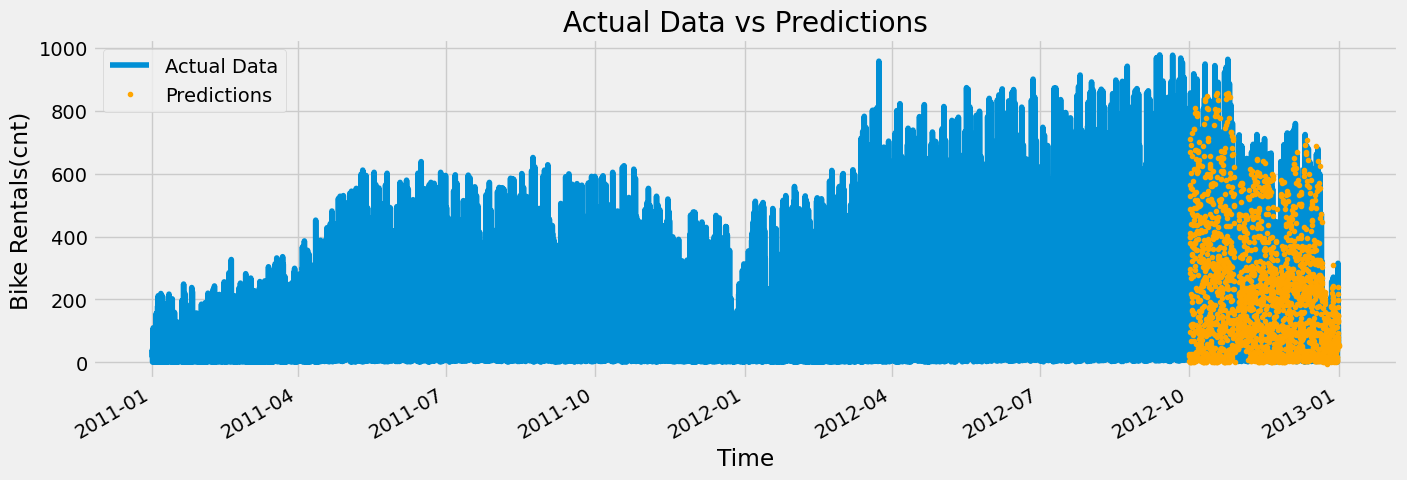

In [25]:
# Ensure that 'prediction' column is added only once
if 'prediction' not in df_clen.columns:
    test['prediction'] = reg.predict(dtest)
    df_clen = df_clen.merge(test[['prediction']], how='left', left_index=True, right_index=True)

# Plot the actual and predicted values
ax = df_clen[['cnt']].plot(figsize=(15, 5))
df_clen['prediction'].plot(ax=ax, style='.', color='orange')

# Add labels and legend
plt.legend(['Actual Data', 'Predictions'])
ax.set_title('Actual Data vs Predictions')
plt.xlabel('Time')
plt.ylabel('Bike Rentals(cnt)')

# Show the plot
plt.show()

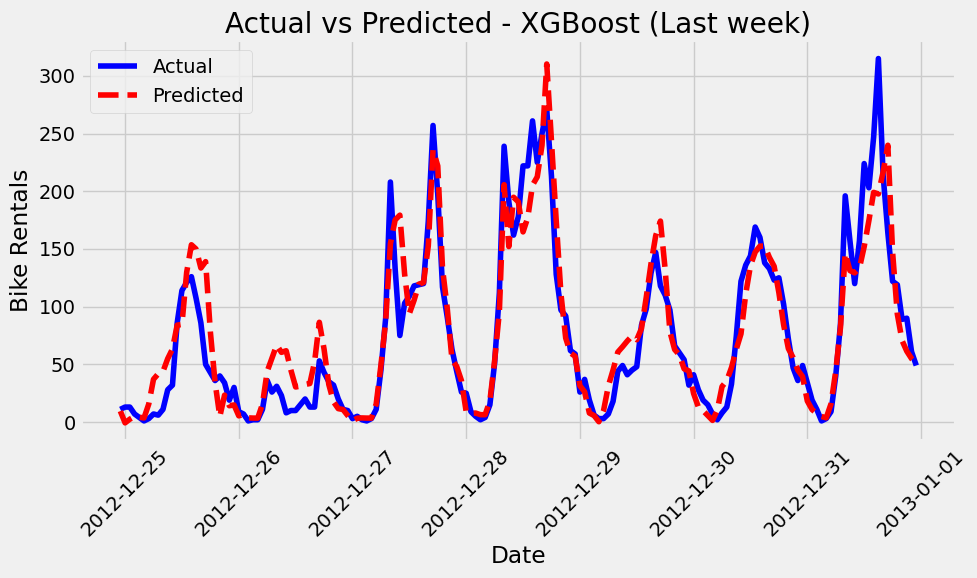

In [26]:
# Ensure that 'prediction' column is added only once
if 'prediction' not in df_clen.columns:
    test['prediction'] = reg.predict(dtest)
    df_clen = df_clen.merge(test[['prediction']], how='left', left_index=True, right_index=True)


# Determine the end date of your test data:
end_date = y_test_xgb.index[-1]  # The last datetime in your test data

# Calculate the start date for the last week:
start_date = end_date - pd.Timedelta(days=7)  # One week prior to the end date

# Filter the data for the last week:
y_test_last_week = y_test_xgb.loc[start_date:end_date]

# Filter the predictions for the last week, ensuring alignment with the actuals:
y_pred_xgb_last_week = df_clen['prediction'].loc[start_date:end_date]

# Plot actual vs predicted for one month
plt.figure(figsize=(10, 6))
plt.plot(y_test_last_week.index, y_test_last_week, label='Actual', color='blue')
plt.plot(y_test_last_week.index, y_pred_xgb_last_week, label='Predicted', color='red', linestyle='dashed')
plt.title('Actual vs Predicted - XGBoost (Last week)')
plt.xlabel('Date')
plt.ylabel('Bike Rentals')
plt.legend()
plt.xticks(rotation=45)  # Rotate labels if needed
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [27]:
# @title **Evaluating XGBoost**
rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test_xgb, y_pred_xgb)

print(f"XGBoost - RMSE: {rmse_xgb:.2f}")
print(f"XGBoost - MAE: {mae_xgb:.2f}")

# Calculate RMSE and MAE for the last week
rmse_xgb_last_week = np.sqrt(mean_squared_error(y_test_last_week, y_pred_xgb_last_week))
mae_xgb_last_week = mean_absolute_error(y_test_last_week, y_pred_xgb_last_week)

# Print the results for the last week
print(f"XGBoost (Last Week) - RMSE: {rmse_xgb_last_week:.2f}")
print(f"XGBoost (Last Week) - MAE: {mae_xgb_last_week:.2f}")

XGBoost - RMSE: 56.41
XGBoost - MAE: 36.57
XGBoost (Last Week) - RMSE: 26.90
XGBoost (Last Week) - MAE: 18.78


The XGBoost model demonstrates reasonable predictive performance for bike rentals, with an RMSE of 57.31 and an MAE of 37.13 on the overall test set. This indicates that, on average, the model's predictions deviate from the actual bike rentals by approximately 57 bikes (RMSE) and 37 bikes (MAE).

Interestingly, the model exhibits significantly better performance when focusing solely on the last week of the test data, achieving an RMSE of 27.29 and an MAE of 19.61. This improvement suggests that the model is particularly adept at capturing recent trends or patterns in bike rental demand.